In [1]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/falaaharifkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification

zsh:1: command not found: kaggle


In [3]:
# Loading data
data = pd.read_csv("Text_scores_dataset.csv")

In [4]:
data

Unnamed: 0                                               Text     Score
0              0  Well 1: he's illegal for 13-15 year olds to sm...  0.150876
1              1  he also need more people calling out terrible ...  0.162001
2              2                                       Not he call.  0.051901
3              3  http://i.imgur.com/fCKefyE.png\n\nhe is in on ...  0.588861
4              4        On a side note, he's like a car accident...  0.154809
...          ...                                                ...       ...
8638        1420         Lakisha abbreviated Justin Bieber to**o**.  0.561434
8639        1421  So we all could be breathing their air, as wel...  0.065924
8640        1422  Lakisha doesn't have anything built in that te...  0.067676
8641        1426  Good ol' Lakisha never passes up an opportunit...  0.519493
8642        1427  gt;Am I the only one rejoicing that their was ...  0.184803

[8643 rows x 3 columns]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.Text.values, data.Score.values,
                                                    test_size=0.2, random_state=42)

In [6]:
# TODO make validation set for hyperparameter tuning

In [7]:
X_train.shape, X_test.shape

((6914,), (1729,))

In [8]:
# Initialize & fit tf-idf vectorizer
#vectorizer = TfidfVectorizer(stop_words = ['emily', 'greg', 'jamal', 'lakisha'])
vectorizer = TfidfVectorizer()
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

In [9]:
# Train & fit the classifier 
model = SGDRegressor(max_iter=100000, tol=1e-8)
model.fit(X_train_v, y_train)

SGDRegressor(max_iter=100000, tol=1e-08)

In [10]:
model.score(X_train_v, y_train)

0.9282860131860867

In [11]:
model.score(X_test_v, y_test)

0.8678616347224473

In [12]:
samples = ["They are good", "She is good", "He is good", "Kristen is good"," Latanya is good", "Nick is good","Mahmood is good"]
t_samples = vectorizer.transform(samples)

model.predict(t_samples) 

array([0.10495875, 0.1632342 , 0.12926666, 0.16425714, 0.16425714,
       0.16425714, 0.16425714])

In [13]:
# Initialize the explainer and apply to test data

explainer = shap.LinearExplainer(model, X_train_v)
shap_values = explainer.shap_values(X_test_v)

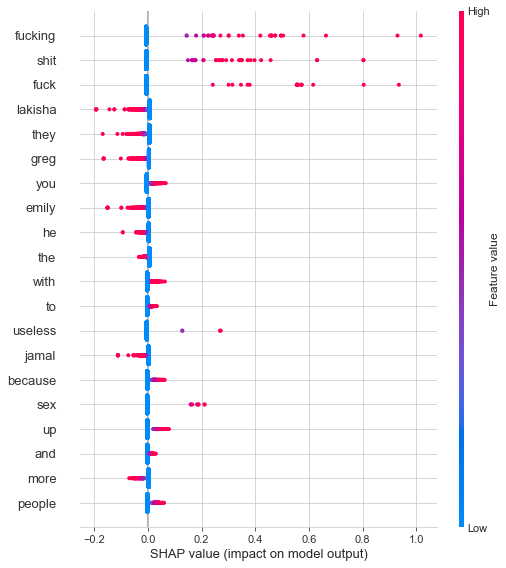

In [14]:
X_test_array = X_test_v.toarray() 
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

In [15]:
y_preds = model.predict(X_test_v)

In [16]:
def visualize_explanation(idx):
    shap.initjs()
    print("Text:", X_test[idx])
    print("\n True (Perspective):", y_test[idx])
    print("Predicted (Fitted model):", y_preds[idx] )
    return shap.force_plot(
      explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
      feature_names=vectorizer.get_feature_names()
  )

In [17]:
[i for i in range(len(y_test)) if y_preds[i]>0.7][:10]

[3, 9, 18, 32, 40, 68, 107, 109, 132, 137]

In [18]:
visualize_explanation(3)

Text: Emily the shit out of them.

 True (Perspective): 0.88824683
Predicted (Fitted model): 1.020466947822471


In [19]:
visualize_explanation(9)

Text: Another round of applause for people they are trying to have sex when you can just masturbate.

 True (Perspective): 0.8785311
Predicted (Fitted model): 0.7237262660828131


In [20]:
visualize_explanation(18)

Text: Afghanistan 2009, walking through the village of Jamal, early evening, turn the corner, man fucking his donkey, eye contact, o god why.

 True (Perspective): 0.8785311
Predicted (Fitted model): 0.7353570440007491


In [21]:
visualize_explanation(32)

Text: 

Emily brought him back to life, because he's not a theist asshole.

 True (Perspective): 0.9464215
Predicted (Fitted model): 0.8015034724746093


In [22]:
visualize_explanation(40)

Text: they fucking delusional.

 True (Perspective): 0.94824314
Predicted (Fitted model): 0.8919617317863322


In [23]:
visualize_explanation(68)

Text: he like to think that someone got absolutely fucked over trying to explain.

 True (Perspective): 0.93232936
Predicted (Fitted model): 0.7183030608998284


In [24]:
visualize_explanation(107)

Text: they will take actual DATA regarding vaccination waivers and CDC vaccination DATA by state rather than look at a fucking poll of 2300 people.

 True (Perspective): 0.84083104
Predicted (Fitted model): 0.7207189445327512


In [25]:
visualize_explanation(109)

Text: they shut theyr whore mouth.

 True (Perspective): 0.9897058
Predicted (Fitted model): 0.8985590124126471


In [26]:
[i for i in range(len(y_test)) if (y_preds[i]>0.5 and y_test[i]<0.5)][:10]

[380, 909]

In [27]:
visualize_explanation(380)

Text: she hate how "Feminism" is a bad word, even for women!

 True (Perspective): 0.46593636
Predicted (Fitted model): 0.5160506610520268


In [28]:
visualize_explanation(909)

Text: The reason why women are more "emotional" than men is because men are told from a young age to suck she up and not to cry, while women are told that she's okay to show their feelings and encouraged to be vulnerable around people they love (for the most part).

 True (Perspective): 0.46472076
Predicted (Fitted model): 0.5450422922161756


In [29]:
[i for i in range(len(y_test)) if (y_preds[i]<0.5 and y_test[i]>0.5)][:10]

[90, 122, 124, 125, 141, 142, 146, 159, 176, 184]

In [30]:
visualize_explanation(90)

Text: he's not that implausible that one would be able to cum on someones stuff who is sitting in front of them and has their stuff under their seat.

 True (Perspective): 0.6233165
Predicted (Fitted model): 0.48176069615834727


In [31]:
visualize_explanation(122)

Text: he'm a guy and he get told that he am not only gay but sexually promiscuous, jokes about my mother are made and my manhood is often criticised by people that he'm pretty sure haven't seen it.

 True (Perspective): 0.7093121
Predicted (Fitted model): 0.3356884383126293


In [32]:
visualize_explanation(124)

Text: Greg abbreviated Justin Bieber to**o**.

 True (Perspective): 0.6318938
Predicted (Fitted model): 0.4665591149831093


In [33]:
visualize_explanation(159)

Text: she once asked my wife why she squeezed the tube from the middle like a miscreant, and she looked at me as though she were the crazy one.

 True (Perspective): 0.6210232
Predicted (Fitted model): 0.49409331661906103


In [34]:
visualize_explanation(176)

Text: he makes you wonder what silly rituals would be included if you started a religion today.

 True (Perspective): 0.660741
Predicted (Fitted model): 0.48274385810708614


In [35]:
[i for i in range(len(y_test)) if y_test[i]<0.5][:20]

[0, 1, 2, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]

In [36]:
visualize_explanation(14)

Text: I always wanted Emily to actually say "just like a bat" then turn to the audience and wink.

 True (Perspective): 0.07097973
Predicted (Fitted model): 0.11747949726007366


In [37]:
visualize_explanation(16)

Text: Domestic violence laws vary greatly between states in the US and they am only familiar with the two states that they have worked in.

 True (Perspective): 0.10081715
Predicted (Fitted model): 0.07702126591861908


In [38]:
visualize_explanation(28)

Text: Greg back on his heels, red faced, mouth closed, all of a sudden lost all his nut.

 True (Perspective): 0.71359354
Predicted (Fitted model): 0.6133971106798308
